# **Hi-C Analysis Demo**

First, let's download the data for this notebook.

In [12]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

In [13]:
from utils import download_file

if not os.path.exists(path="data"):
    os.makedirs(name="data")

download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10493866",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fhic_analysis_demo%2FGSE63525_GM12878_insitu_primary_30-250k.cool&dl=1",
    save_filename="data/GSE63525_GM12878_insitu_primary_30-250k.cool",
)

Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fhic_analysis_demo%2FGSE63525_GM12878_insitu_primary_30-250k.cool&dl=1 -> data/GSE63525_GM12878_insitu_primary_30-250k.cool
Total size: 73,821,485 bytes


100%|██████████| 73.8M/73.8M [00:01<00:00, 44.4MiB/s]

Download completed: data/GSE63525_GM12878_insitu_primary_30-250k.cool


Next, we use [cooler](https://github.com/open2c/cooler) to load the real-world Hi-C data.

In [14]:
import cooler

cool_data = cooler.Cooler(store="data/GSE63525_GM12878_insitu_primary_30-250k.cool")
print(f"Data resolution: {cool_data.binsize:,} bp")
print(f"Available chromosomes: {cool_data.chromnames}")

Data resolution: 250,000 bp
Available chromosomes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT']


Then we load the [Knight-Ruiz](https://doi.org/10.1093/imanum/drs019) balanced contact matrix of chromosome 1.

In [15]:
selected_chrom = "1"
contact_matrix = cool_data.matrix(balance="KR").fetch(selected_chrom)

Next, we remove NaNs (these occur due to the matrix balancing), zero entries, and unalignable regions from the contact matrix.

In [16]:
import numpy as np

# Remove NaNs.
observed_ids = np.argwhere(~np.isnan(contact_matrix))
observed_row_ids = observed_ids[:, 0]
observed_col_ids = observed_ids[:, 1]
observed_contact_matrix_values = contact_matrix[observed_row_ids, observed_col_ids]

# Remove 0.0s.
nonzero_mask = ~np.isclose(observed_contact_matrix_values, 0.0)
observed_row_ids = observed_row_ids[nonzero_mask]
observed_col_ids = observed_col_ids[nonzero_mask]
observed_contact_matrix_values = observed_contact_matrix_values[nonzero_mask]

# Remove unalignable regions.
unique_observed_ids = np.unique(np.concatenate([observed_row_ids, observed_col_ids]))
observed_row_ids = np.searchsorted(unique_observed_ids, observed_row_ids)
observed_col_ids = np.searchsorted(unique_observed_ids, observed_col_ids)

The number of contacts is inversely related to the (Euclidean) distance in three-dimensional space, since neighboring regions are more likely to interact.
Therefore, we convert the contact matrix $\mathbf{C}$ into a proxy of the Euclidean distance matrix (EDM) $\mathbf{D}$ using a conversion factor $\alpha$:

$$
D_{i,j} = \frac{1}{C^{\alpha}_{i,j}}.
$$

In [17]:
import torch

alpha = 1
observed_ed_mat_values = torch.from_numpy(
    np.power(observed_contact_matrix_values, -alpha)
).float()

We initialize a gradient-tracking PyTorch tensor filled with random numbers from a uniform distribution on the interval $[0,1)$.
This is the point set that we want to optimize.

In [18]:
# torch.manual_seed(seed=42)
n_points = len(unique_observed_ids)
predicted_coord_mat = torch.rand(size=(3, n_points), requires_grad=True)

For the optimization procedure, we also need a function to convert our to-be-optimized point set into its corresponding EDM.

In [19]:
def point2edm(coord_mat: torch.Tensor) -> torch.Tensor:
    """Convert a coordinate matrix to a Euclidean distance matrix."""
    gram_mat = coord_mat.T @ coord_mat
    diag_vec = torch.diag(gram_mat).reshape(shape=(-1, 1))
    ones_vec = torch.ones(size=(coord_mat.shape[1], 1))
    ed_mat = diag_vec @ ones_vec.T + ones_vec * diag_vec.T - 2 * gram_mat
    return ed_mat

Finally, we optimize the point set using [Adam](https://doi.org/10.48550/arXiv.1412.6980).

In [20]:
from torch.nn.functional import mse_loss

optimizer = torch.optim.Adam(params=[predicted_coord_mat], lr=1e-1)

n_iterations = 100

for i in range(n_iterations):
    optimizer.zero_grad()
    predicted_ed_mat = point2edm(coord_mat=predicted_coord_mat)
    partial_predicted_ed_mat_values = predicted_ed_mat[
        observed_row_ids, observed_col_ids
    ]
    loss = mse_loss(
        input=partial_predicted_ed_mat_values, target=observed_ed_mat_values
    )
    loss.backward()
    optimizer.step()

    print(f"Iteration [{(i + 1):5}/{n_iterations:5}] | Loss={loss:8f}")

Iteration [    1/  100] | Loss=0.329894
Iteration [    2/  100] | Loss=0.087073
Iteration [    3/  100] | Loss=0.020102
Iteration [    4/  100] | Loss=0.006090
Iteration [    5/  100] | Loss=0.004137
Iteration [    6/  100] | Loss=0.005119
Iteration [    7/  100] | Loss=0.007987
Iteration [    8/  100] | Loss=0.011986
Iteration [    9/  100] | Loss=0.015607
Iteration [   10/  100] | Loss=0.017769
Iteration [   11/  100] | Loss=0.018328
Iteration [   12/  100] | Loss=0.017688
Iteration [   13/  100] | Loss=0.016325
Iteration [   14/  100] | Loss=0.014607
Iteration [   15/  100] | Loss=0.012784
Iteration [   16/  100] | Loss=0.011022
Iteration [   17/  100] | Loss=0.009428
Iteration [   18/  100] | Loss=0.008056
Iteration [   19/  100] | Loss=0.006925
Iteration [   20/  100] | Loss=0.006022
Iteration [   21/  100] | Loss=0.005319
Iteration [   22/  100] | Loss=0.004780
Iteration [   23/  100] | Loss=0.004369
Iteration [   24/  100] | Loss=0.004057
Iteration [   25/  100] | Loss=0.003819


Finally, we plot the optimized point set.

In [21]:
from typing import Any

import matplotlib.pyplot as plt
import numpy.typing as npt


def scatter_3d(coord_mat: npt.NDArray[Any]) -> None:
    """Create a 3D scatter plot of the coordinates."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(*coord_mat)
    plt.show()

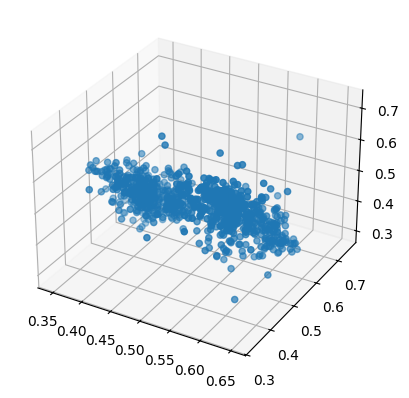

In [22]:
predicted_coord_mat_np = predicted_coord_mat.detach().numpy()
scatter_3d(coord_mat=predicted_coord_mat_np)